**Importing the main libraries**

In [11]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

### Preprocessing pipeline

We will take every image from each folder and do the following steps to it:
* Convert to grayscale, normalize it (max abs scaling) and the resize it
* One hot encode the labels (since they're 26+)

In [12]:
def load_data(folder_path, img_size=64, num_samples_per_class=500):
    data = []
    labels = []
    folders = os.listdir(folder_path)
    
    for label in tqdm(folders, desc="Loading data", unit="class"):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            image_names = os.listdir(label_path)
            sampled_images = random.sample(image_names, min(num_samples_per_class, len(image_names)))
            
            for img_name in sampled_images:
                img_path = os.path.join(label_path, img_name)
                # Load image in grayscale mode
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Resize the image to the target size
                    img_resized = cv2.resize(img, (img_size, img_size))
                    data.append(img_resized)
                    # Convert label to numeric: 'A'=0, ..., 'Z'=25, 'Nothing'=26, 'Space'=27
                    if label == "Nothing":
                        labels.append(26)
                    elif label == "Space":
                        labels.append(27)
                    else:
                        labels.append(ord(label) - ord('A'))

    data = np.array(data)
    labels = np.array(labels)
    
    # Max abs scaling
    data = data.astype('float32') / 255.0
    
    # Reshape data
    data = data.reshape(-1, img_size, img_size, 1)  # (num_samples, height, width, channels)
    
    return data, labels

In [13]:
train_data, train_labels = load_data('/kaggle/input/american-sign-language/ASL_Dataset/Train')
test_data, test_labels = load_data('/kaggle/input/american-sign-language/ASL_Dataset/Test')

train_labels = to_categorical(train_labels, num_classes=28)
test_labels = to_categorical(test_labels, num_classes=28)

Loading data: 100%|██████████| 28/28 [00:01<00:00, 21.26class/s]


### Looking at our preprocessed samples

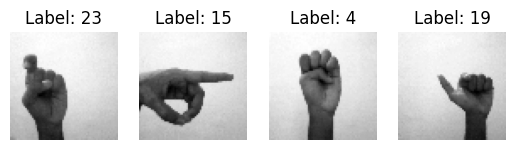

In [14]:
def display_random_samples(data, labels, num_samples=3):
    indices = np.random.choice(len(data), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(data[idx].reshape(64, 64), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[idx])}") 
        plt.axis('off')
    plt.show()


display_random_samples(train_data, train_labels, 4)

### Model building (CNN based architecture for classificaiton)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
def create_simple_cnn(input_shape=(64, 64, 1), num_classes=28):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def create_improved_cnn(input_shape=(64, 64, 1), num_classes=28):
    model = Sequential()
    
    model.add(Input(input_shape))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
  
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [17]:
model = create_improved_cnn()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,268 (1.63 MB)

 Trainable params: 425,308 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [18]:
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Name of the file to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # We want to minimize the validation loss
    verbose=1  # Print messages when saving
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='min',  # Stop when the quantity monitored has stopped decreasing
    verbose=1  # Print messages when stopping
)

In [19]:
history = model.fit(train_data, train_labels, 
                    validation_data=(test_data, test_labels), 
                    epochs=20,callbacks=[checkpoint, early_stopping] , 
                    batch_size=64)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.5838 - loss: 1.4891
Epoch 1: val_loss improved from inf to 9.76408, saving model to best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 106s 466ms/step - accuracy: 0.5848 - loss: 1.4855 - val_accuracy: 0.0357 - val_loss: 9.7641
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9958 - loss: 0.0422
Epoch 2: val_loss did not improve from 9.76408
219/219 ━━━━━━━━━━━━━━━━━━━━ 101s 462ms/step - accuracy: 0.9958 - loss: 0.0422 - val_accuracy: 0.0357 - val_loss: 10.8723
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9992 - loss: 0.0133
Epoch 3: val_loss improved from 9.76408 to 0.37464, saving model to best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 101s 462ms/step - accuracy: 0.9992 - loss: 0.0133 - val_accuracy: 0.8571 - val_loss: 0.3746
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9984 - loss: 0.0107
Epoch 4: val_loss improved from 0.37464 to 0.00020, saving model to bes

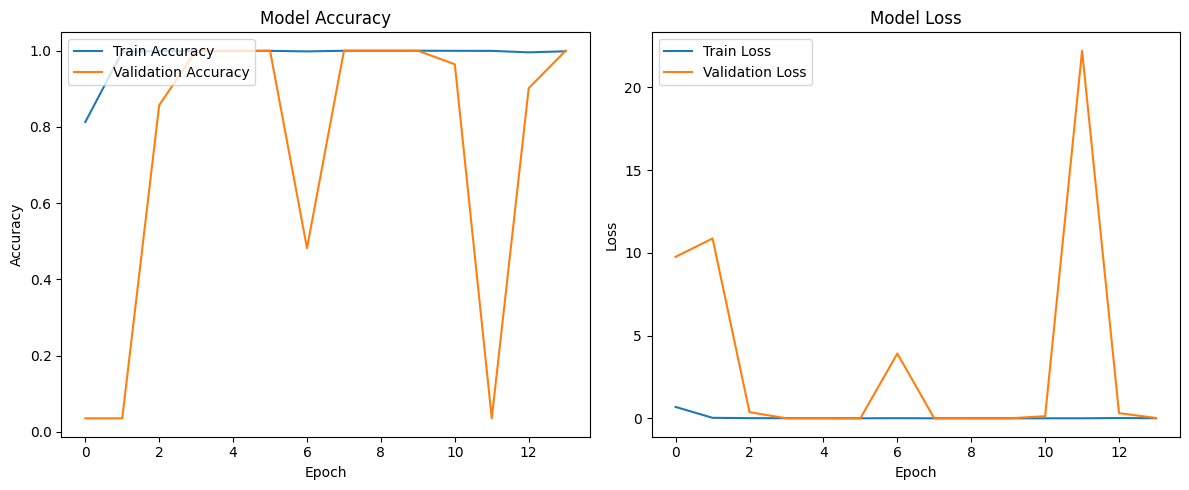

In [20]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Loading our saved model

In [21]:
model = load_model('best_model.keras')

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [22]:
predicted_classes

array([13, 13, 13, 13, 17, 17, 17, 17, 27, 27, 27, 27,  1,  1,  1,  1,  8,
        8,  8,  8,  5,  5,  5,  5,  7,  7,  7,  7,  4,  4,  4,  4, 20, 20,
       20, 20, 12, 12, 12, 12, 23, 23, 23, 23, 10, 10, 10, 10, 16, 16, 16,
       16, 24, 24, 24, 24, 18, 18, 18, 18,  6,  6,  6,  6,  0,  0,  0,  0,
       14, 14, 14, 14, 19, 19, 19, 19, 21, 21, 21, 21, 25, 25, 25, 25,  2,
        2,  2,  2, 15, 15, 15, 15, 11, 11, 11, 11, 22, 22, 22, 22,  3,  3,
        3,  3, 26, 26, 26, 26,  9,  9,  9,  9])

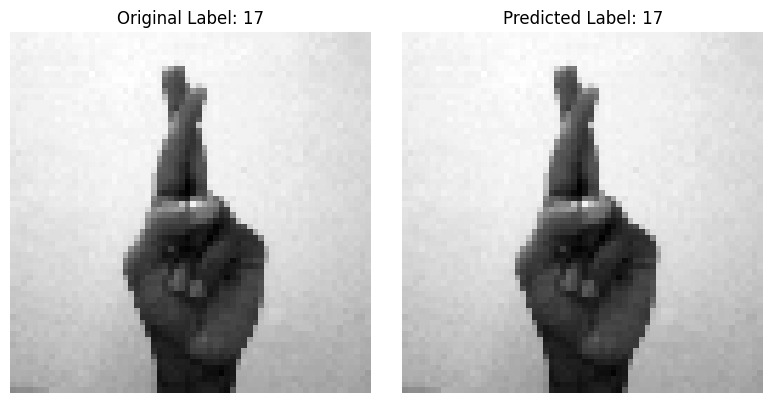

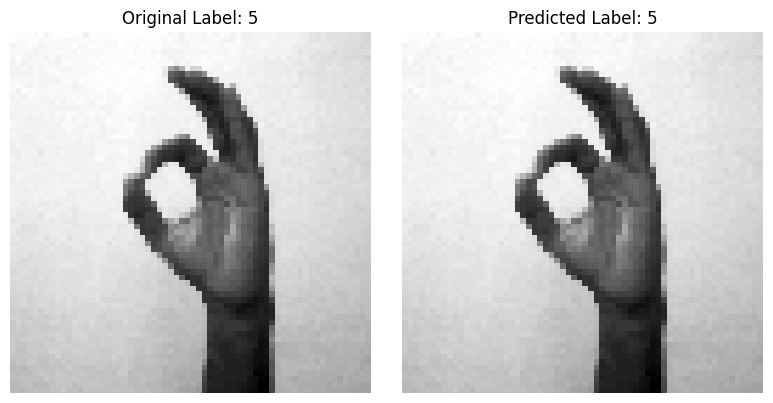

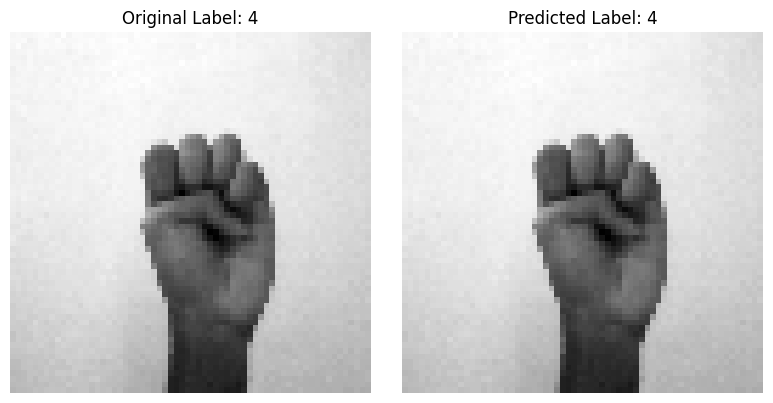

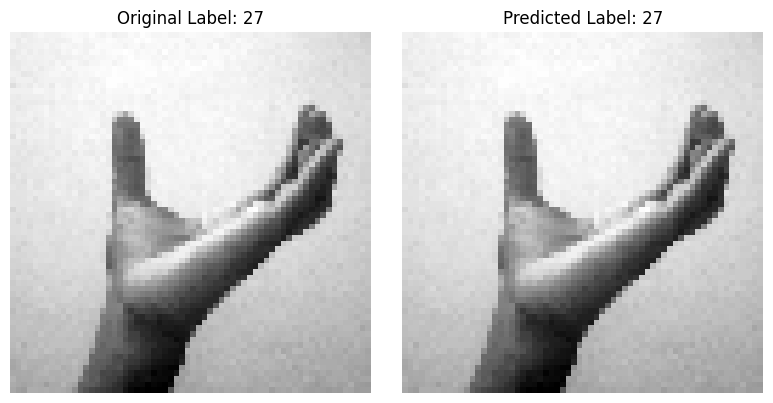

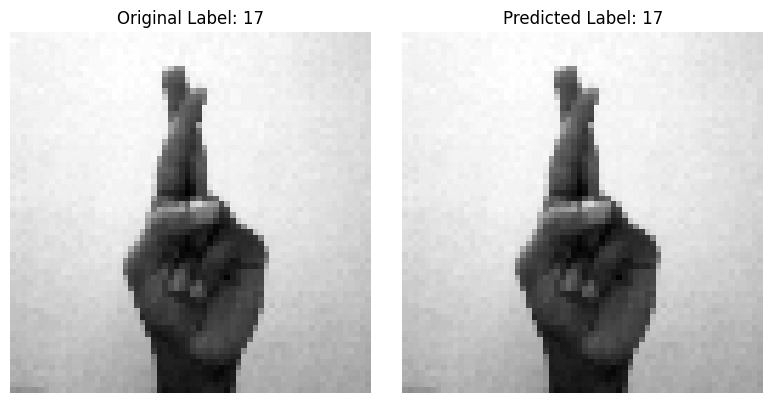

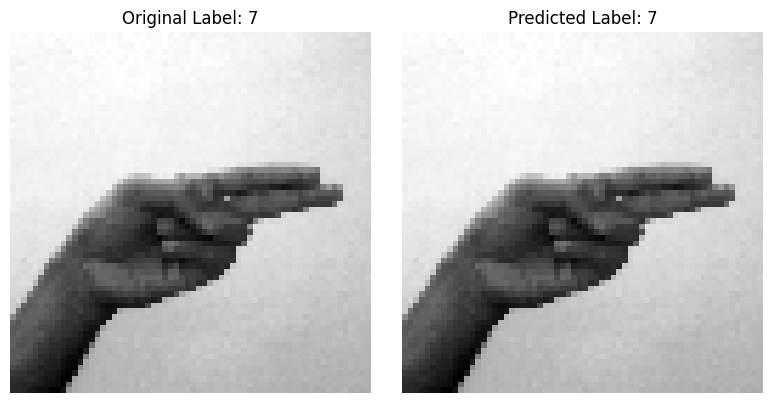

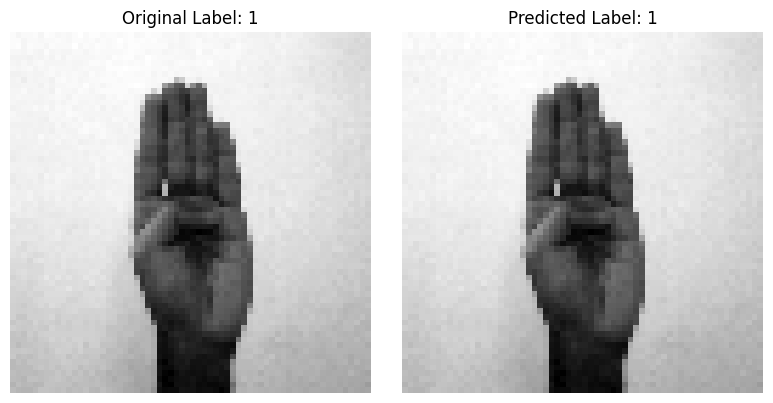

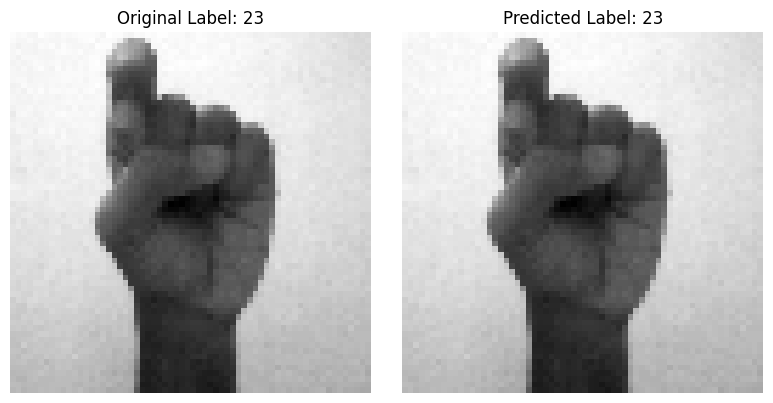

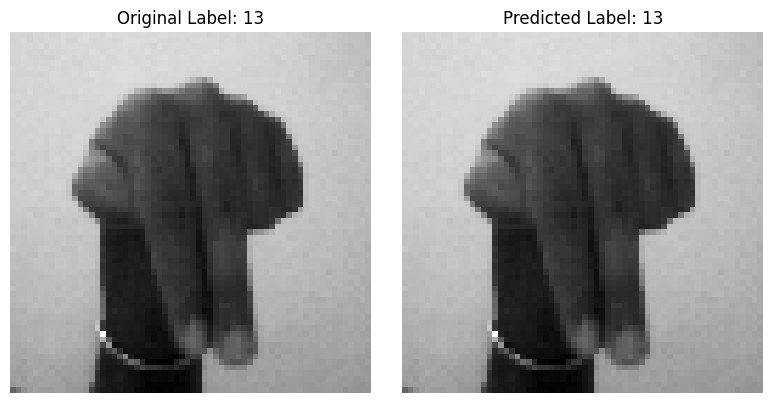

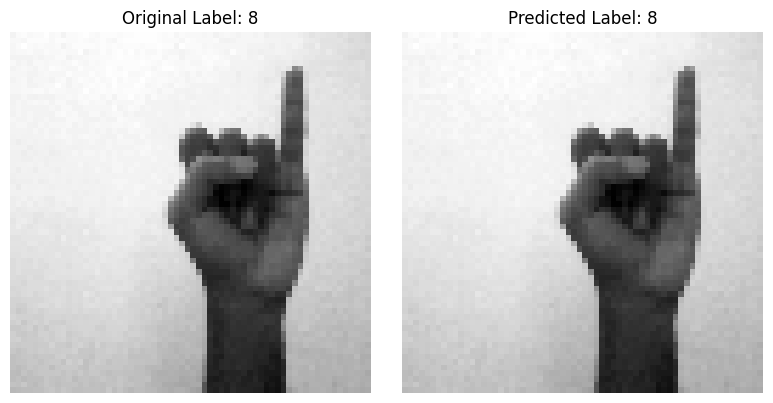

In [23]:
def display_image_with_labels(index):

    original_label = np.argmax(test_labels[index])
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(test_data[index], cmap='gray')
    axes[0].set_title(f"Original Label: {original_label}")
    axes[0].axis('off') 
    
  
    axes[1].imshow(test_data[index].reshape(64, 64), cmap='gray')
    axes[1].set_title(f"Predicted Label: {predicted_classes[index]}")
    axes[1].axis('off')  # Hide the axes
    
    plt.tight_layout()
    plt.show()

for i in np.random.randint(1, 50, 10):
    display_image_with_labels(i)

#  **MODEL 2**

In [24]:
model2 =  create_simple_cnn()
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,188 (6.21 MB)

 Trainable params: 1,628,188 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
checkpoint = ModelCheckpoint(
    'simple-cnn.keras',  # Name of the file to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # We want to minimize the validation loss
    verbose=1  # Print messages when saving
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='min',  # Stop when the quantity monitored has stopped decreasing
    verbose=1  # Print messages when stopping
)

In [26]:
history = model2.fit(train_data, train_labels, 
                    validation_data=(test_data, test_labels), 
                    epochs=20,callbacks=[checkpoint, early_stopping] , 
                    batch_size=64)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.1606 - loss: 2.9584
Epoch 1: val_loss improved from inf to 0.77043, saving model to simple-cnn.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.1612 - loss: 2.9561 - val_accuracy: 0.8304 - val_loss: 0.7704
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6071 - loss: 1.2545
Epoch 2: val_loss improved from 0.77043 to 0.29881, saving model to simple-cnn.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.6073 - loss: 1.2537 - val_accuracy: 0.8214 - val_loss: 0.2988
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7763 - loss: 0.6775
Epoch 3: val_loss improved from 0.29881 to 0.15956, saving model to simple-cnn.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - accuracy: 0.7764 - loss: 0.6773 - val_accuracy: 0.9375 - val_loss: 0.1596
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8509 - loss: 0.4479
Epoch 4: val_loss improved from 0.159

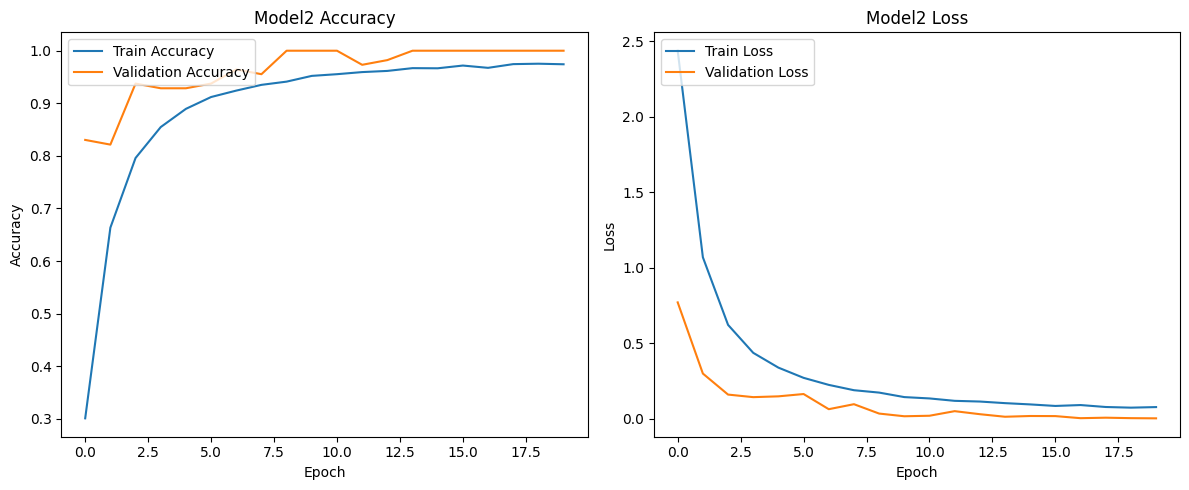

In [27]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
model_simple = load_model('simple-cnn.keras')

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [29]:
predicted_classes

array([13, 13, 13, 13, 17, 17, 17, 17, 27, 27, 27, 27,  1,  1,  1,  1,  8,
        8,  8,  8,  5,  5,  5,  5,  7,  7,  7,  7,  4,  4,  4,  4, 20, 20,
       20, 20, 12, 12, 12, 12, 23, 23, 23, 23, 10, 10, 10, 10, 16, 16, 16,
       16, 24, 24, 24, 24, 18, 18, 18, 18,  6,  6,  6,  6,  0,  0,  0,  0,
       14, 14, 14, 14, 19, 19, 19, 19, 21, 21, 21, 21, 25, 25, 25, 25,  2,
        2,  2,  2, 15, 15, 15, 15, 11, 11, 11, 11, 22, 22, 22, 22,  3,  3,
        3,  3, 26, 26, 26, 26,  9,  9,  9,  9])

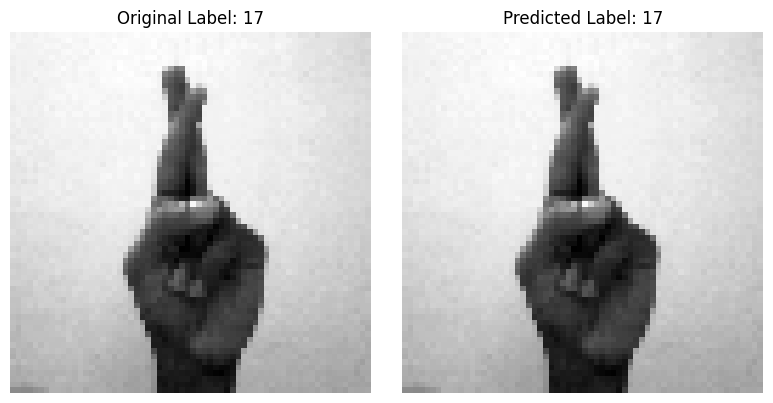

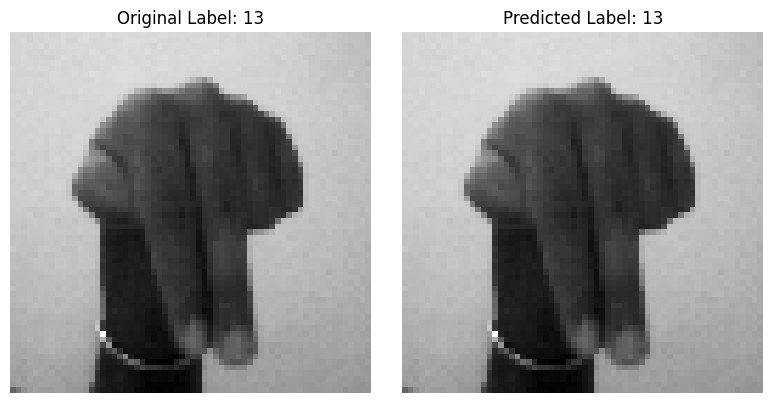

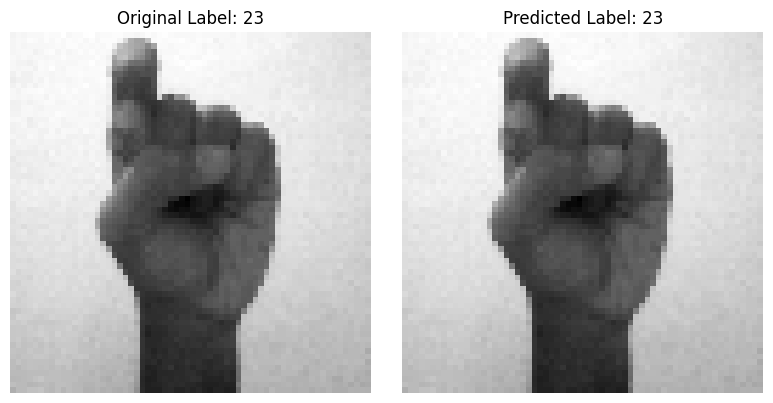

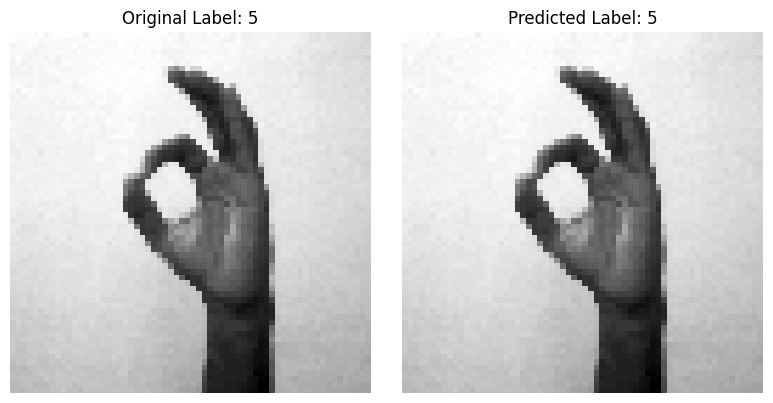

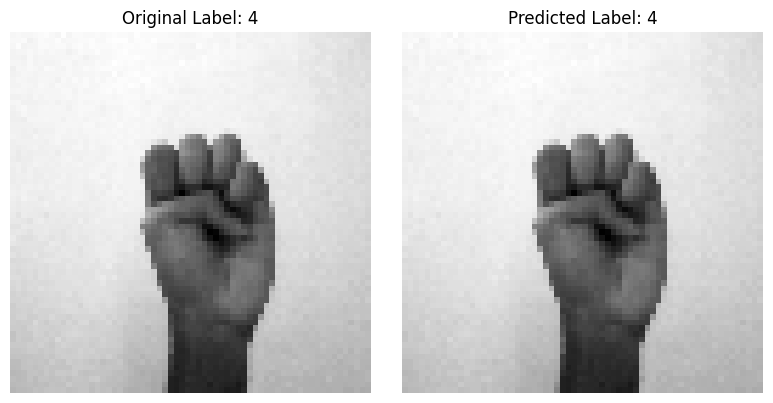

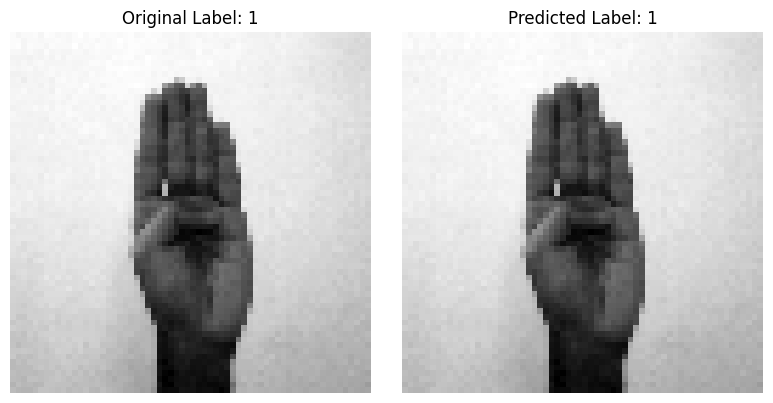

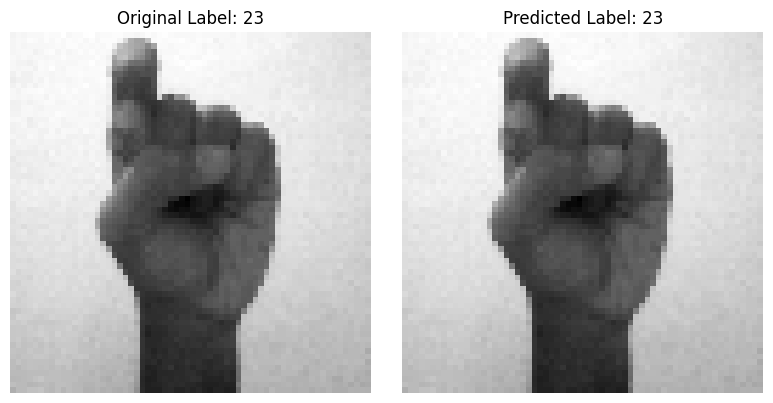

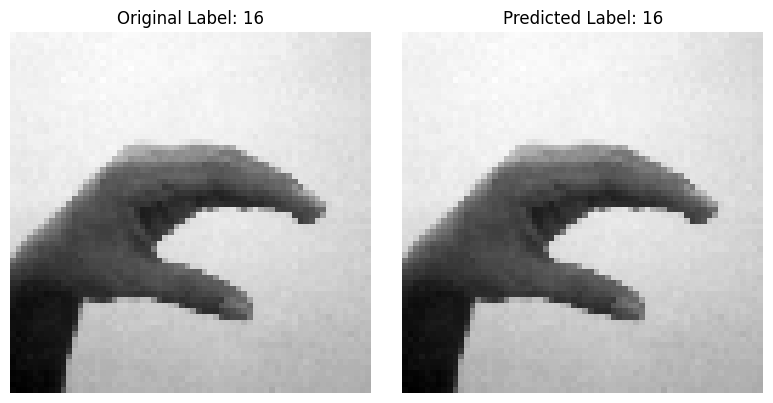

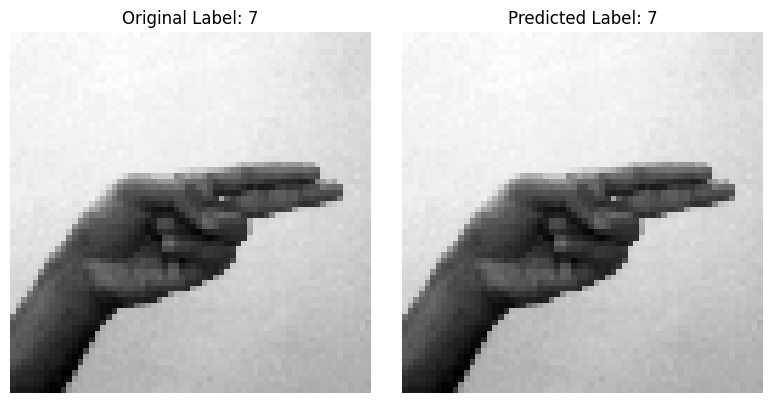

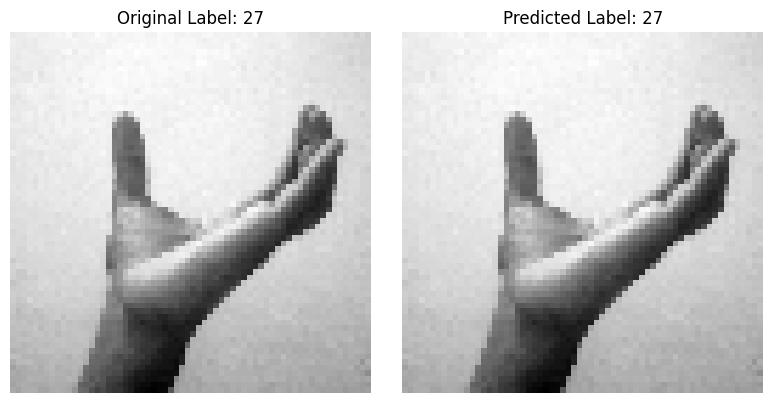

In [30]:
def display_image_with_labels(index):

    original_label = np.argmax(test_labels[index])
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(test_data[index], cmap='gray')
    axes[0].set_title(f"Original Label: {original_label}")
    axes[0].axis('off') 
    
  
    axes[1].imshow(test_data[index].reshape(64, 64), cmap='gray')
    axes[1].set_title(f"Predicted Label: {predicted_classes[index]}")
    axes[1].axis('off')  # Hide the axes
    
    plt.tight_layout()
    plt.show()

for i in np.random.randint(1, 50, 10):
    display_image_with_labels(i)

In [31]:
def load_data2(folder_path, img_size=64):
    data = []
    labels = []
    folders = os.listdir(folder_path)
    
    for label in tqdm(folders, desc="Loading data", unit="class"):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            image_names = os.listdir(label_path)
            sampled_images = random.sample(image_names,len(image_names))
            
            for img_name in sampled_images:
                img_path = os.path.join(label_path, img_name)
                # Load image in grayscale mode
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Resize the image to the target size
                    img_resized = cv2.resize(img, (img_size, img_size))
                    data.append(img_resized)
                    # Convert label to numeric: 'A'=0, ..., 'Z'=25, 'Nothing'=26, 'Space'=27
                    if label == "Nothing":
                        labels.append(26)
                    elif label == "Space":
                        labels.append(27)
                    else:
                        labels.append(ord(label) - ord('A'))

    data = np.array(data)
    labels = np.array(labels)
    
    # Max abs scaling
    data = data.astype('float32') / 255.0
    
    # Reshape data
    data = data.reshape(-1, img_size, img_size, 1)  # (num_samples, height, width, channels)
    
    return data, labels

# **MODEL 3**

In [32]:
train_data2, train_labels2 = load_data2('/kaggle/input/american-sign-language/ASL_Dataset/Train')
test_data2, test_labels2 = load_data2('/kaggle/input/american-sign-language/ASL_Dataset/Test')

train_labels2 = to_categorical(train_labels2, num_classes=28)
test_labels2 = to_categorical(test_labels2, num_classes=28)

Loading data: 100%|██████████| 28/28 [00:00<00:00, 77.47class/s]


In [33]:
checkpoint = ModelCheckpoint(
    'simple-cnn2.keras',  # Name of the file to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # We want to minimize the validation loss
    verbose=1  # Print messages when saving
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='min',  # Stop when the quantity monitored has stopped decreasing
    verbose=1  # Print messages when stopping
)


In [34]:
history = model2.fit(train_data2, train_labels2, 
                    validation_data=(test_data2, test_labels2), 
                    epochs=20,callbacks=[checkpoint, early_stopping] , 
                    batch_size=64)

Epoch 1/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9679 - loss: 0.0965
Epoch 1: val_loss improved from inf to 0.00033, saving model to simple-cnn2.keras
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 414s 160ms/step - accuracy: 0.9679 - loss: 0.0965 - val_accuracy: 1.0000 - val_loss: 3.2988e-04
Epoch 2/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9812 - loss: 0.0532
Epoch 2: val_loss did not improve from 0.00033
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 410s 159ms/step - accuracy: 0.9812 - loss: 0.0532 - val_accuracy: 1.0000 - val_loss: 8.8855e-04
Epoch 3/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9865 - loss: 0.0393
Epoch 3: val_loss improved from 0.00033 to 0.00016, saving model to simple-cnn2.keras
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 404s 156ms/step - accuracy: 0.9865 - loss: 0.0393 - val_accuracy: 1.0000 - val_loss: 1.5789e-04
Epoch 4/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9890 - loss: 0.0321
Epoch 4: val_loss improved from 0.00016 to 0

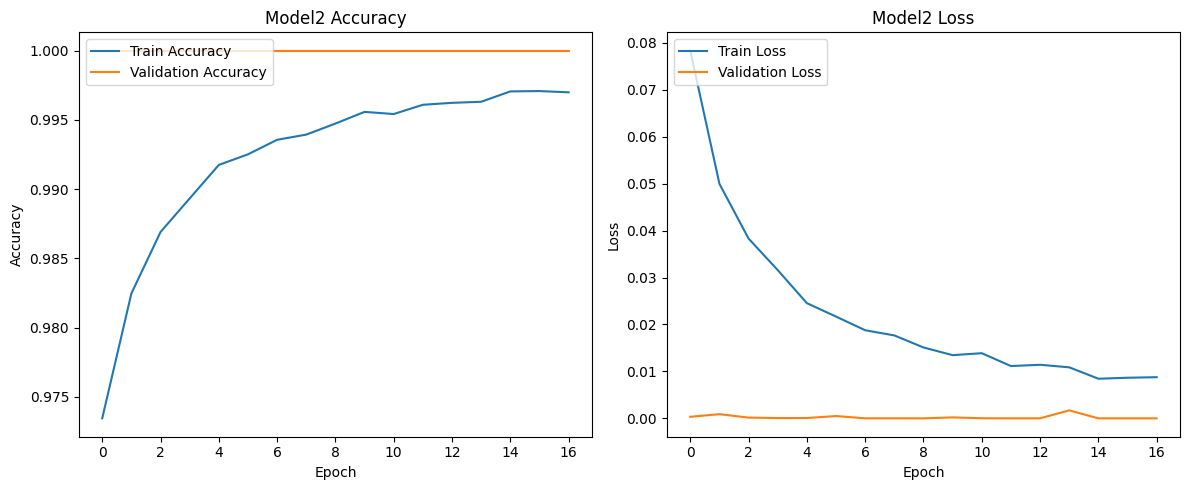

In [35]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
model_simple2 = load_model('simple-cnn2.keras')

predictions = model.predict(test_data)
predicted_classes2 = np.argmax(predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [41]:
predicted_classes2

array([13, 13, 13, 13, 17, 17, 17, 17, 27, 27, 27, 27,  1,  1,  1,  1,  8,
        8,  8,  8,  5,  5,  5,  5,  7,  7,  7,  7,  4,  4,  4,  4, 20, 20,
       20, 20, 12, 12, 12, 12, 23, 23, 23, 23, 10, 10, 10, 10, 16, 16, 16,
       16, 24, 24, 24, 24, 18, 18, 18, 18,  6,  6,  6,  6,  0,  0,  0,  0,
       14, 14, 14, 14, 19, 19, 19, 19, 21, 21, 21, 21, 25, 25, 25, 25,  2,
        2,  2,  2, 15, 15, 15, 15, 11, 11, 11, 11, 22, 22, 22, 22,  3,  3,
        3,  3, 26, 26, 26, 26,  9,  9,  9,  9])

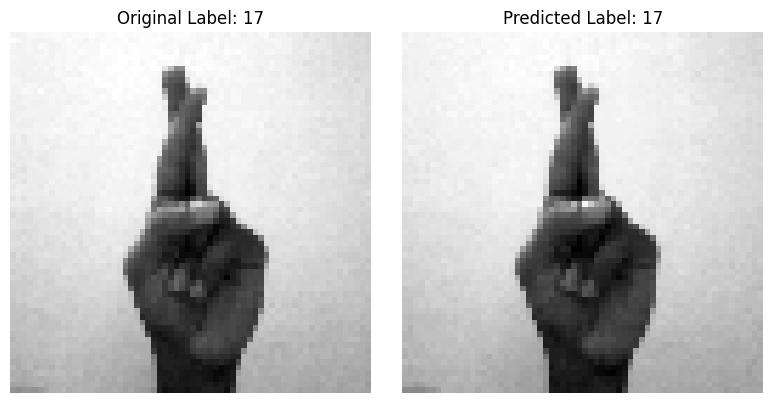

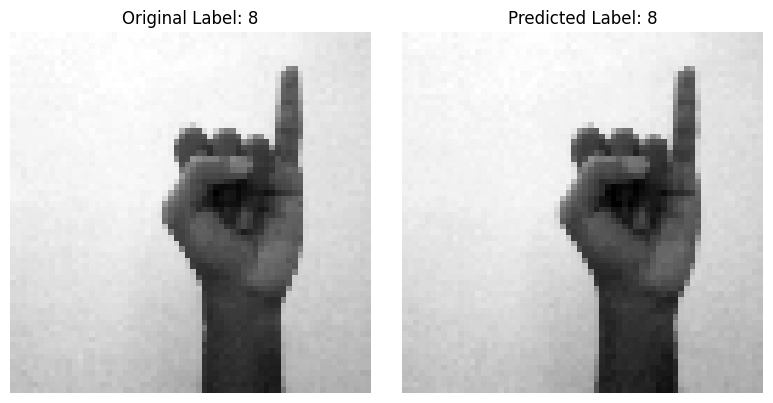

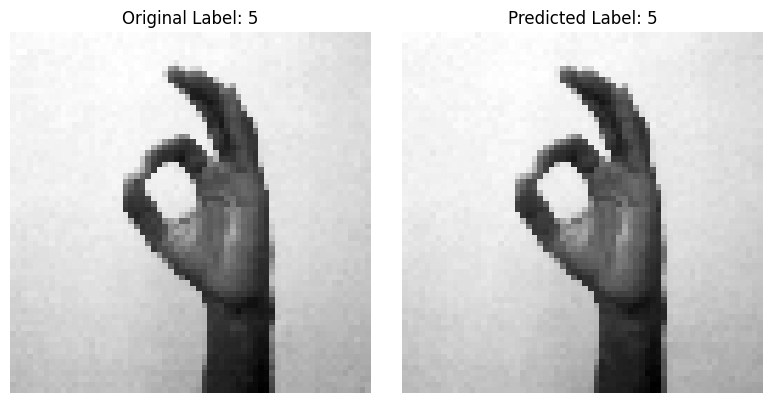

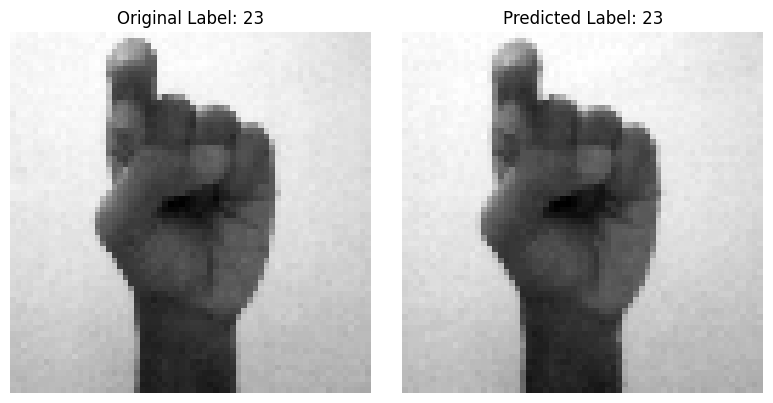

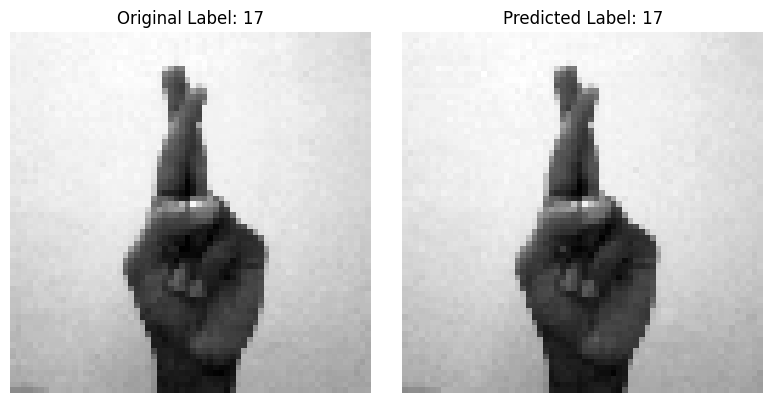

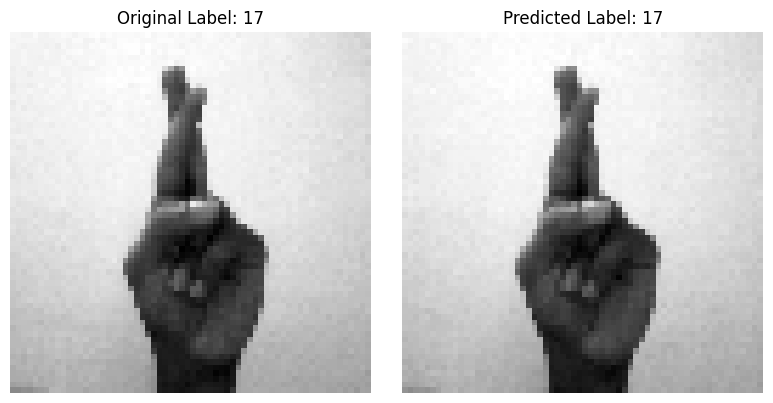

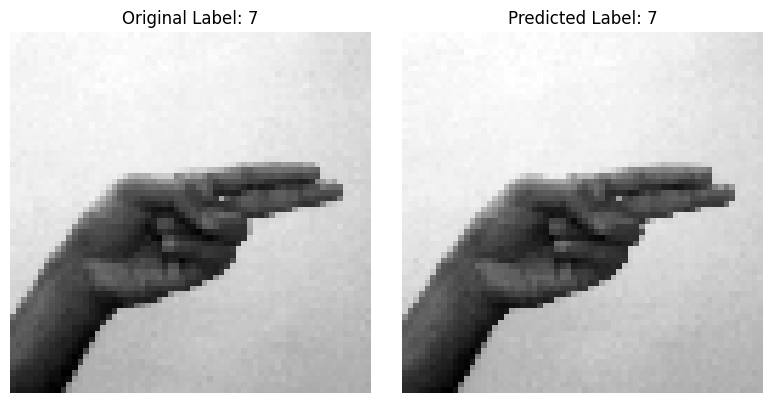

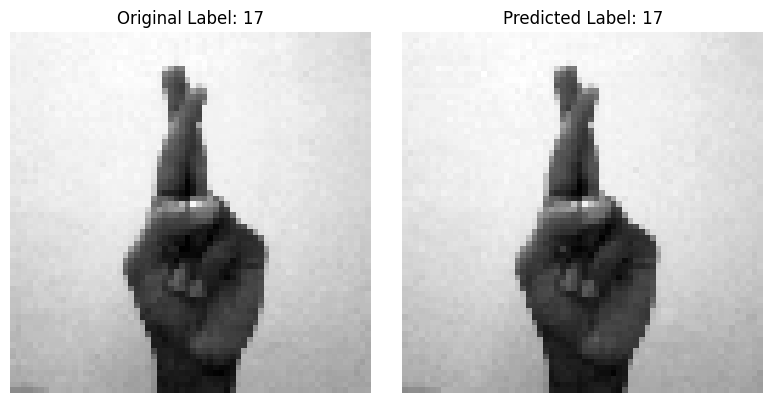

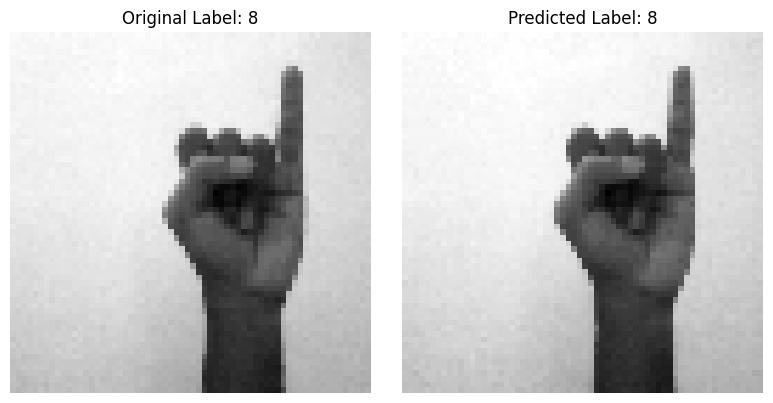

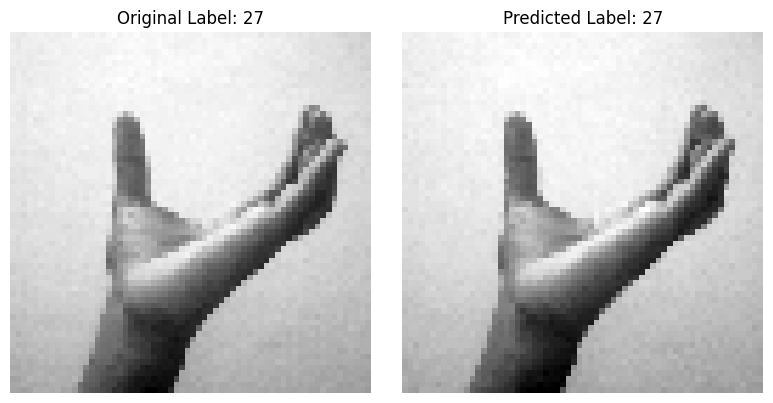

In [42]:
def display_image_with_labels(index):

    original_label = np.argmax(test_labels2[index])
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(test_data2[index], cmap='gray')
    axes[0].set_title(f"Original Label: {original_label}")
    axes[0].axis('off') 
    
  
    axes[1].imshow(test_data[index].reshape(64, 64), cmap='gray')
    axes[1].set_title(f"Predicted Label: {predicted_classes2[index]}")
    axes[1].axis('off')  # Hide the axes
    
    plt.tight_layout()
    plt.show()

for i in np.random.randint(1, 50, 10):
    display_image_with_labels(i)